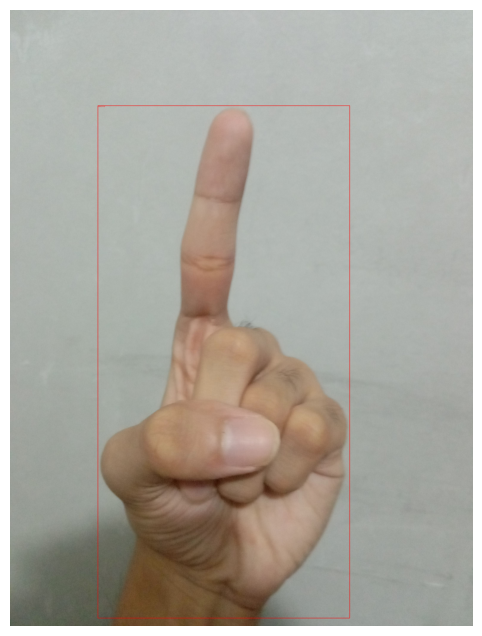

Detection 1:
  Label: hand
  Confidence Score: 0.4177
  Bounding Box: [591.8048706054688, 645.3059692382812, 2290.85302734375, 4107.03369140625]



In [11]:
import torch
from PIL import Image, ImageDraw
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt

model_id = "./IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

# Specify the path to your local image
image_path = "./2_CLASS_DS/test/1/IMG_20240902_143632_Burst01.jpg"
image = Image.open(image_path)

# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "a hand. hand."
inputs = processor(images=image, text=text, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

# Function to draw bounding boxes
def draw_bounding_boxes(image, results):
    draw = ImageDraw.Draw(image)
    colors = ["red", "blue", "green", "yellow", "purple"]  # Add more colors if needed
    
    for i, (box, label, score) in enumerate(zip(results[0]["boxes"], results[0]["labels"], results[0]["scores"])):
        box = [round(i, 2) for i in box.tolist()]
        color = colors[i % len(colors)]
        draw.rectangle(box, outline=color, width=3)
        draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill=color)
    
    return image

# Draw bounding boxes on the image
image_with_boxes = draw_bounding_boxes(image.copy(), results)

# Display the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

# Print detection results
for i, (box, label, score) in enumerate(zip(results[0]["boxes"], results[0]["labels"], results[0]["scores"])):
    print(f"Detection {i+1}:")
    print(f"  Label: {label}")
    print(f"  Confidence Score: {score:.4f}")
    print(f"  Bounding Box: {box.tolist()}")
    print()